In [75]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa

import numpy as np
import pandas as pd
!pip install ujson
import ujson as json
from pathlib import Path
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

BASEPATH = Path('../input/herbarium-2021-fgvc8/train')
PREDPATH = Path('../input/herbarium-2021-fgvc8/test')
CROP_PERCENT = 6 #(%)

In [2]:
## Enable TPU
'''
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('runnint on TPU', tpu.master())
except ValueError:
    tpu = None
    print('ValueError')
    
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu_cluster_resolver=tpu)
    print('strategy created: ')
else:
    strategy = tf.distribute.get_strategy()
    print('tpu false')
print('REPLICAS: ', strategy.num_replicas_in_sync)
print(strategy)
'''

"\ntry:\n    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()\n    print('runnint on TPU', tpu.master())\nexcept ValueError:\n    tpu = None\n    print('ValueError')\n    \nif tpu:\n    tf.config.experimental_connect_to_cluster(tpu)\n    tf.tpu.experimental.initialize_tpu_system(tpu)\n    strategy = tf.distribute.experimental.TPUStrategy(tpu_cluster_resolver=tpu)\n    print('strategy created: ')\nelse:\n    strategy = tf.distribute.get_strategy()\n    print('tpu false')\nprint('REPLICAS: ', strategy.num_replicas_in_sync)\nprint(strategy)\n"

# Let's read metadata.json

In [2]:
train_meta = '../input/herbarium-2021-fgvc8/train/metadata.json'
pred_meta =  '../input/herbarium-2021-fgvc8/test/metadata.json'

### Load information from json meta file
### Input: file path to json meta file
### Output: dictionary formatted json information
def load_json(file_path):
    print('loading: ', file_path)
    with open(file_path, 'r') as json_file:
        json_dict = json.load(json_file)
    print('complete: ', file_path)
    return json_dict

### concatenate data into pandas frame
### Input: dictionary formatted json information
### Output: pandas dataset
def concat_dataset(json_dict, annotations=True):
    print('concat start...')
    images = pd.json_normalize(json_dict['images'])
    
    if annotations:
        annotations = pd.json_normalize(json_dict['annotations'])
        dataset = pd.concat([annotations[['category_id', 'id']], images[['file_name', 'height', 'width']]], axis=1)
    else:
        dataset = images
    print('concat complete')
    return dataset

    
train_dict = load_json(train_meta)
pred_dict = load_json(pred_meta)

dataset = concat_dataset(train_dict,annotations=True)
pred_ds = concat_dataset(pred_dict, annotations=False)

display(dataset)
display(pred_ds)

loading:  ../input/herbarium-2021-fgvc8/train/metadata.json
complete:  ../input/herbarium-2021-fgvc8/train/metadata.json
loading:  ../input/herbarium-2021-fgvc8/test/metadata.json
complete:  ../input/herbarium-2021-fgvc8/test/metadata.json
concat start...
concat complete
concat start...
concat complete


,category_id,id,file_name,height,width
0,60492,1814367,images/604/92/1814367.jpg,1000,678
1,10824,1308257,images/108/24/1308257.jpg,1000,666
2,33076,1270453,images/330/76/1270453.jpg,1000,739
3,24799,1123834,images/247/99/1123834.jpg,1000,672
4,17018,1042410,images/170/18/1042410.jpg,1000,675
...,...,...,...,...,...
2257754,51130,812040,images/511/30/812040.jpg,1000,666
2257755,35499,701754,images/354/99/701754.jpg,1000,671
2257756,56547,662006,images/565/47/662006.jpg,1000,678
2257757,57499,234505,images/574/99/234505.jpg,1000,681


,file_name,height,id,license,width
0,images/000/0.jpg,1000,0,0,680
1,images/000/1.jpg,1000,1,0,681
2,images/000/2.jpg,1000,2,0,676
3,images/000/3.jpg,1000,3,0,666
4,images/000/4.jpg,1000,4,0,676
...,...,...,...,...,...
243015,images/243/243015.jpg,1000,243015,0,739
243016,images/243/243016.jpg,1000,243016,0,703
243017,images/243/243017.jpg,1000,243017,0,681
243018,images/243/243018.jpg,1000,243018,0,680


In [84]:
## Get image information
min_height = min([dataset['height'].min(), pred_ds['height'].min()])
min_width = min([dataset['width'].min(), pred_ds['width'].min()])
print('org minimum height:', min_height)
print('org minimum width:', min_width)

min_height = int(min_height - 2*(min_height * CROP_PERCENT/100))
min_width = int(min_width - 2*(min_width * CROP_PERCENT/100))
                           
print('minimum height:', min_height)
print('minimum width:', min_width)
category_num = dataset['category_id'].unique().shape[0]

org minimum height: 515
org minimum width: 486
minimum height: 453
minimum width: 427


# Show some images

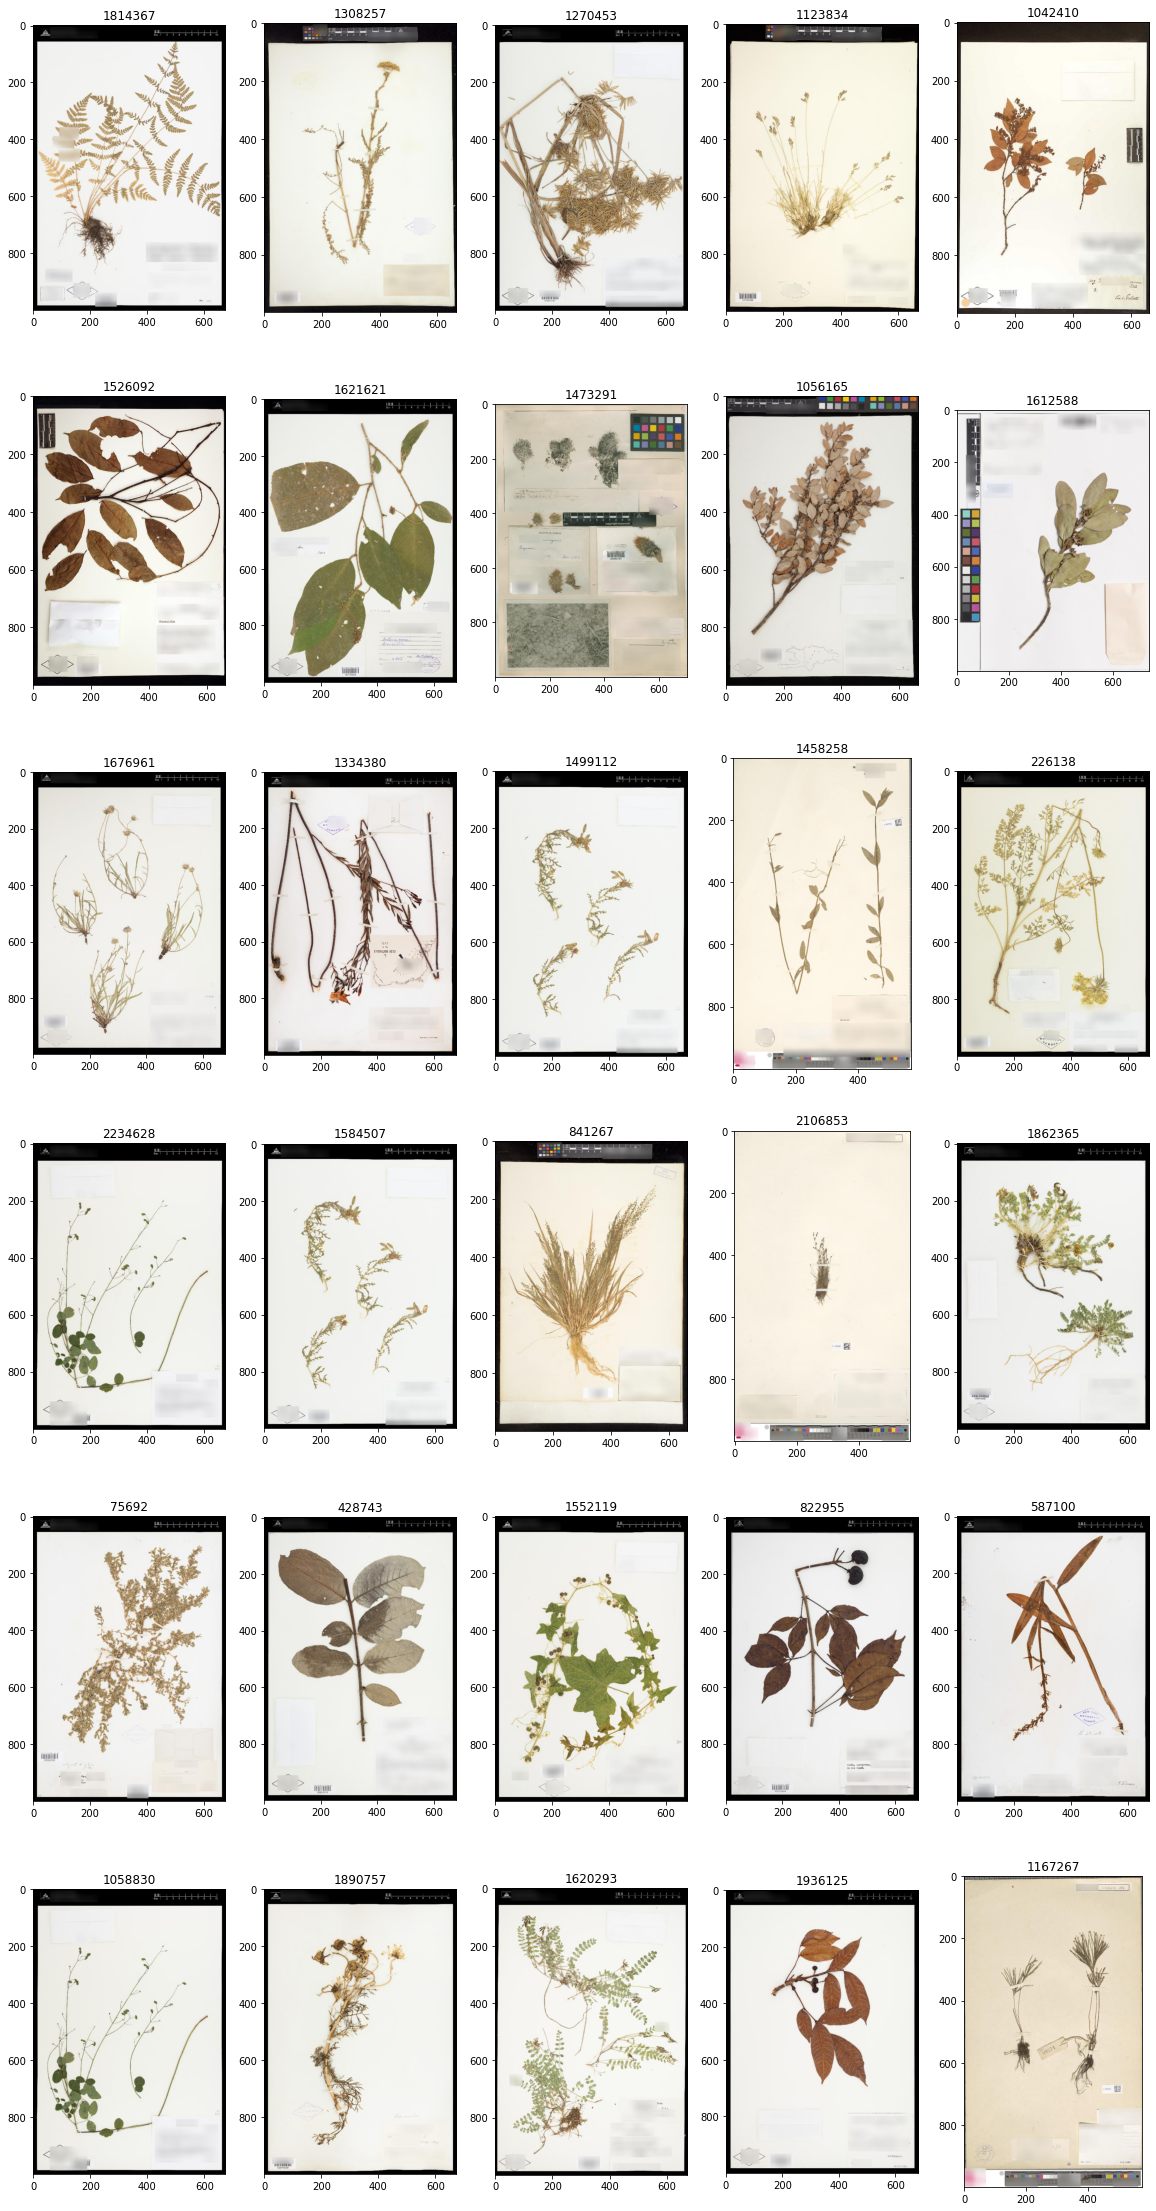

In [22]:
_ = plt.figure(figsize=(20,40))

# Random choice
rnd = np.random.randint(0,1000,30)

for i, x in enumerate(dataset.loc[rnd,'file_name']):
    im_path = BASEPATH / x
    with Image.open(im_path, 'r') as img:
        _ = plt.subplot(6,5,i+1)
        _ = plt.imshow(img)
        _ = plt.title(str(dataset.iloc[i, 1]))

In [141]:
## For experimental cell ##
## It looks that there are some non-required pixels. Can we remove it?

## Remove edge region
def crop_image(tensor_img, CROP_PERCENT=1):
    CROP_RATIO = CROP_PERCENT / 100.
    print(tf.shape(tensor_img))
    crop_ver = tf.cast(tf.shape(tensor_img)[0], tf.float32) * tf.constant(CROP_RATIO)
    
    HEIGHT = int(tensor_img.shape[0] * CROP_RATIO)
    WIDTH = int(tensor_img.shape[1] * CROP_RATIO)
    tensor_img = tf.image.crop_to_bounding_box(tensor_img, HEIGHT,WIDTH ,image.shape[0] - 2*crop_ver, image.shape[1] - 2*WIDTH)
    
    return tensor_img

## Check result of cropping method
path = str(BASEPATH/str(dataset.loc[0,'file_name']))
image = tf.io.read_file(path)
image = tf.image.decode_jpeg(image, channels=3)
image = crop_image(image, CROP_PERCENT=CROP_PERCENT).numpy()
_ = plt.imshow(image)

tf.Tensor([1000  678    3], shape=(3,), dtype=int32)


InvalidArgumentError: cannot compute Slice as input #2(zero-based) was expected to be a int32 tensor but is a float tensor [Op:Slice]

# Image preprocessing

In [123]:
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = crop_image(image, CROP_PERCENT=CROP_PERCENT)
    image = tf.image.resize(image, [min_width, min_height])
    
    image /= 255.0    
    return image

def get_tensor_dataset(base_path, dataset, is_train=False):
    all_img_paths = dataset['file_name'].map(lambda x:str(base_path/x))
    path_ds = tf.data.Dataset.from_tensor_slices(all_img_paths)
    # example of path_ds --> tf.Tensor(b'../input/herbarium-2021-fgvc8/train/images/604/92/1814367.jpg', shape=(), dtype=string)
    image_ds = path_ds.map(preprocess_image, num_parallel_calls=-1)
    
    if is_train:
        all_labels = dataset['category_id']   
        labels = tf.data.Dataset.from_tensor_slices(tf.cast(all_labels, tf.float32))
        data = tf.data.Dataset.zip((image_ds, labels))
    else:
        data = image_ds
    
    data = data.batch(64)
    data = data.prefetch(buffer_size=-1)
    return data

train = get_tensor_dataset(BASEPATH, dataset, is_train=True)
pred = get_tensor_dataset(PREDPATH, pred_ds, is_train=False)

Tensor("Shape:0", shape=(3,), dtype=int32)
Tensor("Shape:0", shape=(3,), dtype=int32)


# Baseline model

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, 3, activation='relu', input_shape=[min_width, min_height, 3]))
model.add(keras.layers.MaxPooling2D((2,2)))
#model.add(keras.layers.Conv2D(64, 3, activation='relu'))
#model.add(keras.layers.MaxPooling2D((2,2)))
#model.add(keras.layers.Conv2D(64, 3, activation='relu'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(category_num, 'softmax'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train, epochs=5)

ppp = model.predict(pred)

Epoch 1/5
  440/35278 [..............................] - ETA: 6:28:48 - loss: 2617.4535 - accuracy: 7.0755e-04